In [2]:
import os
import numpy as np

from sklearn.cluster import KMeans,HDBSCAN
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import multiprocessing as mp
import matplotlib.pyplot as plt
from pprint import pprint
from shutil import copyfile

import warnings


In [3]:
protein_pdb = "/mnt/sdc/lanwei/ADIPOR/whole/ADIPOR1-A.pdb"
peptide_pdb_dir = '/mnt/sdc/lanwei/ADIPOR/whole/final_best_pose_pdb/'
point_plot = f'{peptide_pdb_dir}/cluster_point_plot.png'
cluster_result = f'{peptide_pdb_dir}/cluster_result.txt'

In [4]:
protein_coords = []
with open(protein_pdb) as f:
    for line in f:
        if line.startswith('ATOM'):
            x = float(line[30:38]) 
            y = float(line[38:46])
            z = float(line[46:54]) 
            protein_coords.append([x, y, z])
print(len(protein_coords))

2544


In [5]:
peptide_coords = []
peptide_names = []
for pdb in os.listdir(peptide_pdb_dir):
    if pdb.endswith('.pdb'):
        coords = []
        with open(os.path.join(peptide_pdb_dir, pdb)) as f:
            for line in f:
                if line.startswith('ATOM'):
                    x = float(line[30:38])
                    y = float(line[38:46]) 
                    z = float(line[46:54])
                    coords.append([x, y, z])
        peptide_coords.append(coords)
        peptide_names.append(pdb.split('.')[0])

In [10]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords):
    contacted_coords = []
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0 
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))
            if dist < 4:
                contact += 1
        if contact > 0:
            contacted_coords.append(list(p_coord) + [contact])
        else:
            contacted_coords.append([0,0,0,0])
    return contacted_coords

contact_matrices = []

with mp.Pool() as pool:
    results = [pool.apply_async(calc_contacts, args=(i, peptide_coords, protein_coords)) 
            for i in range(len(peptide_coords))]
    contact_matrices = [r.get() for r in results]
print(len(contact_matrices))

299


In [11]:
contact_matrixs = []
for dists in contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)

In [13]:
np.shape(contact_matrixs)

(299, 2544)

In [22]:
weights = np.array([0.2, 0.2, 0.2, 0.6]) # 定义一个权重向量，表示x,y,z,C的重要程度
contact_matrices_weighted = contact_matrices * weights # 将每个四元素向量与权重向量相乘
contact_matrices_weighted = contact_matrices_weighted.sum(axis=2) # 沿着第三个轴求和，得到一个标量
print(contact_matrices_weighted.shape)
np.set_printoptions(threshold=np.inf)

(299, 2544)


In [23]:
contact_matrices_weighted[0]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [24]:
def cluster_score(estimator, X, y):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) <= 1:
        return 0
  
    return silhouette_score(X, labels)

HDBSCAN(min_cluster_size=2) this params score is 0.24898763876521404
HDBSCAN(min_cluster_size=3) this params score is 0.2264940669553667
HDBSCAN(min_cluster_size=4) this params score is 0.15907404109127327
HDBSCAN() this params score is 0.14277389889727496
HDBSCAN(min_cluster_size=6) this params score is 0.13040439156721903
HDBSCAN(min_cluster_size=7) this params score is 0.11730107757683596
HDBSCAN(min_cluster_size=8) this params score is 0.1271388663168391
HDBSCAN(min_cluster_size=9) this params score is 0.12359288564378682
HDBSCAN(min_cluster_size=10) this params score is 0.12270409978503458
HDBSCAN(min_cluster_size=11) this params score is 0.11655882603091003
HDBSCAN(min_cluster_size=12) this params score is 0.10965707850643704
HDBSCAN(min_cluster_size=13) this params score is 0.10439644458740237
HDBSCAN(min_cluster_size=14) this params score is 0.10356127729910863
HDBSCAN(min_cluster_size=2)


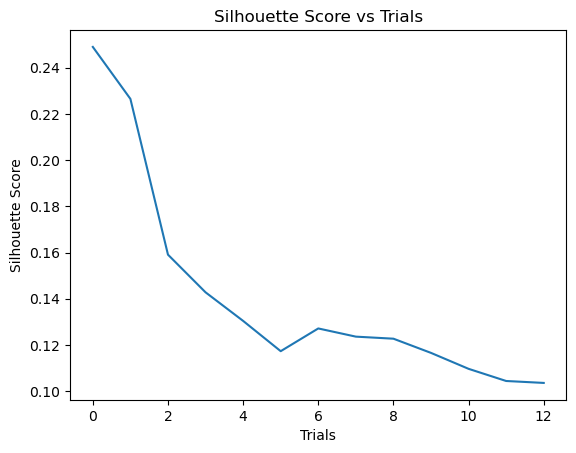

In [25]:

scores = {}
for clusters_number in range(2, 15):

    km = HDBSCAN(min_cluster_size = clusters_number) 
    labels = km.fit_predict(contact_matrixs)
    score = cluster_score(km ,contact_matrixs,  labels)
    scores[km] = score
    print(f'{km} this params score is {score}')

'''
scores = {}
for clusters_number in range(2, 8):

    km = KMeans(n_clusters = clusters_number,n_init=10) 
    labels = km.fit_predict(contact_matrixs)
    score = cluster_score(km ,contact_matrixs,  labels)
    scores[km] = score
    print(f'{km} this params score is {score}')
'''



plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Trials')
plt.show

print(max(scores, key=scores.get))



In [26]:
km = KMeans(n_clusters=2,n_init=10) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

KMeans(n_clusters=2, n_init=10) this params score is 0.22925391328155728


In [28]:
km = HDBSCAN(min_cluster_size=2) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

HDBSCAN(min_cluster_size=2) this params score is 0.24898763876521404


In [29]:
cluster_keys = {}
for label in set(labels):
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
final_label = []
for label in sorted(cluster_keys):
        print(f'Cluster {label}:{cluster_keys[label]}\n')
f.close()  

Cluster -1:['FAYHITVY']

Cluster 0:['VWHKVHH', 'FLQYF', 'YYFAYH', 'WIYYF', 'VWLQVY', 'WSYYF', 'VKVSLFKK', 'PGLYYF', 'FKKDKAML', 'GLYYF', 'VWHKHYH', 'YLYQF', 'GRYYF', 'FHYYF', 'YHITVY', 'FAYHIT', 'GSYYF', 'HLFYF', 'WQYYF', 'FLYEF', 'YIYYF', 'YFYYF', 'FIYYF', 'VRFLGS', 'MLYYF', 'FRYYF', 'GTYYF', 'GYYYF', 'YLRYF', 'GVYYF', 'WLYEF', 'YFAYHI', 'WLHYF', 'YSYYF', 'WAKVHHH', 'NMPIRFTK', 'WLYYY', 'WNAVEHR', 'VWVKHKH', 'FLYYY', 'TGFLLYHD', 'WLCYF', 'HPYYF', 'KVSLFK', 'IHNIFR', 'AMLFTYDQ', 'VLYATH', 'PNMPIRFT', 'VLLHLEVG', 'GLYYFA', 'WAHVKHH', 'FNYYF', 'FLYKF', 'YLHYF', 'WPYYF', 'WRYYF', 'YLYIF', 'FHCNIPGL', 'HLYFF', 'WLYSF', 'TMRQIL', 'EGERNGLY', 'GLYYW', 'YLYKF', 'VGWRGGG', 'QFYYF', 'FLYRF', 'WLYAF', 'WLYPF', 'YLYHF', 'GAYVYR', 'GDQVWLQV', 'FLNYF', 'YLQYF', 'RNGLYADN', 'FQYYF', 'WLYKF', 'IFRMTE', 'YRSAFSVG', 'KAMLFT', 'PGSGAYVY', 'WAKHHHY', 'TFYYF', 'FKYYF', 'FTYYF', 'FGFVLR', 'HVYYF', 'YVYRSA', 'GWYYF', 'LFKKDKAM', 'GLYNF', 'WNTVEHR', 'IVRFLG', 'FVYYF', 'GGKFWFG', 'LSSVCY', 'FLYNF', 'YLYTF', '

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


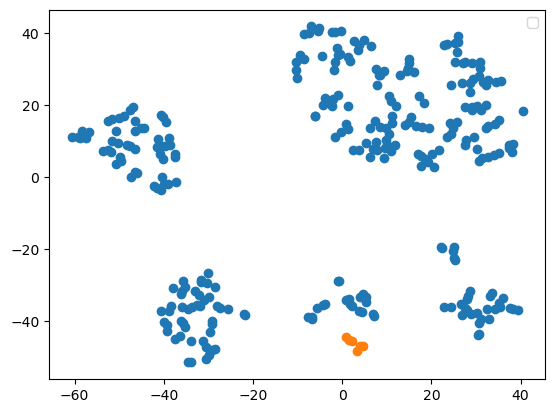

In [30]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(contact_matrixs)

# 2D散点图
fig, ax = plt.subplots()

for i in range(clusters_number):
    ax.scatter(X_tsne[labels==i, 0], 
            X_tsne[labels==i, 1], 
            )
ax.legend()
plt.show()

In [ ]:

cluster_labels_pdb = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

a = 0

for cluster_label_pdb in cluster_labels_pdb:
    print(cluster_label_pdb)
    i = 0
    a = a + 1
  # 定义输出pdb文件名
    out_file = os.path.join(peptide_pdb_dir, f'{a}.pdb' )
    
    for pdb in cluster_label_pdb:
       
        pdb_file = os.path.join(peptide_pdb_dir, pdb + '.pdb')
        with open(out_file, 'a') as f_out:
            with open(pdb_file) as f_in:
              i = i + 1
              f_out.write(f'\nMODEL {i}\n')
              
              # 过滤掉MODEL/END/ENDMDL行
              lines = [line for line in f_in if 'MODEL' not in line 
                        and 'END' not in line and 'ENDMDL' not in line]  

              f_out.write(''.join(lines))

              f_out.write(f_in.read())
              f_out.write('END\n')
              f_out.write('ENDMDL\n\n')


In [ ]:


first_key = list(cluster_keys.keys())[5] # 获取第一个键
first_value = cluster_keys[first_key] # 获取第一个值
result = []
for k, v in cluster_keys.items():
    if k != first_key:
        result.extend(v)

#print(first_key, first_value) 
print(result)
print(len(result))

In [ ]:
another_peptide_coords = []
for pdb_name in result:
    #print(pdb_name)
    pdb_path = os.path.join(peptide_pdb_dir, pdb_name + '.pdb')
    print(pdb_path)
    coords = []
    with open(pdb_path) as f:
        alines = f.readlines()
        for line in alines:
            if line.startswith('ATOM'):
                x = float(line[30:38]) 
                y = float(line[38:46])
                z = float(line[46:54]) 
                coords.append([x, y, z])
    another_peptide_coords.append(coords)    
print(len(another_peptide_coords))                

In [ ]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords):
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))  
            if dist < 6:
                contact += 1
                #break
        
        dists[p_idx] = contact
        
    return dists

another_contact_matrices = []

with mp.Pool() as pool:
    results = [pool.apply_async(calc_contacts, args=(i, another_peptide_coords, protein_coords)) 
            for i in range(len(another_peptide_coords))]
    another_contact_matrices = [r.get() for r in results]
print(len(another_contact_matrices))

In [ ]:
contact_matrixs = []
for dists in another_contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)

In [ ]:
def cluster_score(estimator, X, y):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) <= 1:
        return 0
  
    return silhouette_score(X, labels)
'''
scores = {}
for clusters_number in range(2, 10):

    km = KMeans(n_clusters = clusters_number,n_init=10) 
    labels = km.fit_predict(contact_matrixs)
    score = cluster_score(km ,contact_matrixs,  labels)
    scores[km] = score
    print(f'{km} this params score is {score}')

'''
scores = {}
for clusters_number in range(2, 15):

    km = HDBSCAN(min_cluster_size = clusters_number) 
    labels = km.fit_predict(contact_matrixs)
    score = cluster_score(km ,contact_matrixs,  labels)
    scores[km] = score
    print(f'{km} this params score is {score}')




plt.plot(list(range(len(scores))), scores.values())
plt.xlabel('Trials') 
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Trials')
plt.show

print(max(scores, key=scores.get))


In [ ]:
km = KMeans(n_clusters=6,n_init=10) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

In [ ]:
km = HDBSCAN(min_cluster_size=2) 
labels = km.fit_predict(contact_matrixs)
score = cluster_score(km ,contact_matrixs,  labels)
scores[km] = score
print(f'{km} this params score is {score}')

In [ ]:
cluster_keys = {}
for label in set(labels):
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
final_label = []
for label in sorted(cluster_keys):
        print(f'Cluster {label}:{cluster_keys[label]}\n')


In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(contact_matrixs)

# 2D散点图
fig, ax = plt.subplots()

for i in range(clusters_number):
    ax.scatter(X_tsne[labels==i, 0], 
            X_tsne[labels==i, 1], 
            )
ax.legend()
plt.show()

In [ ]:
first_key = list(cluster_keys.keys())[0] # 获取第一个键
first_value = cluster_keys[first_key] # 获取第一个值
cluster_labels_pdb = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

for cluster_label_pdb in cluster_labels_pdb:
    for pdb in cluster_label_pdb:
        pdb_file = os.path.join(peptide_pdb_dir, pdb + '.pdb')
        
        print(pdb_file)






In [ ]:

cluster_labels_pdb = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

a = 0

for cluster_label_pdb in cluster_labels_pdb:
    i = 0
    a = a + 1
  # 定义输出pdb文件名
    out_file = os.path.join(peptide_pdb_dir, f'{a}.pdb' )
    
    for pdb in cluster_label_pdb:
       
        pdb_file = os.path.join(peptide_pdb_dir, pdb + '.pdb')
        with open(out_file, 'a') as f_out:
            with open(pdb_file) as f_in:
              i = i + 1
              f_out.write(f'\nMODEL {i}\n')
              
              # 过滤掉MODEL/END/ENDMDL行
              lines = [line for line in f_in if 'MODEL' not in line 
                        and 'END' not in line and 'ENDMDL' not in line]  

              f_out.write(''.join(lines))

              f_out.write(f_in.read())
              f_out.write('END\n')
              f_out.write('ENDMDL\n\n')
